In [ ]:
!pip install pyclustering

In [ ]:
!pip install tslearn

In [4]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from dateutil.relativedelta import relativedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from ast import literal_eval
from sklearn.preprocessing import normalize
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder
import seaborn as sns
from tslearn.clustering import KShape

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


##### Extracting quotes from politicians
In the following cell we load the provided metadata file, available [here](https://drive.google.com/drive/folders/1VAFHacZFh0oxSxilgNByb1nlNsqznUf0). This is used for obtaining a list of names of politicians, which we later use for filtering the QuoteBank dataset

In [ ]:
df_meta = pd.read_parquet('/content/drive/MyDrive/ADA/speaker_attributes.parquet')
df_meta = df_meta[df_meta['occupation'].notna()]

# The identifier for the occupation politician in Wikidata is Q82955
politicians = df_meta[df_meta.occupation.apply(lambda x: 'Q82955' in x)]
politicians = politicians[politicians['aliases'].notna()]
politicians = politicians[politicians['label'].notna()]

# Only consider US politicians
politicians = politicians[politicians['nationality'].notna()]
politicians = politicians[politicians.nationality.apply(lambda x: 'Q30' in x)]

# Make a combined list that contains both the aliases and the label names for the politicians
list_of_politicians = list(politicians.aliases.explode())
list_of_politicians += list(politicians.label)

We use the provided [Colab notebook](https://colab.research.google.com/drive/1NqLFrAWAzKxr2dAWHI7m6Ml3gWGF72cA?usp=sharing) for loading the QuoteBank dataset. This script creates a compressed file that is opened in the following cell

In [ ]:
df_reader = pd.read_json('/content/drive/MyDrive/ADA/Quotebank/quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)

df_politicians = pd.concat([
    chunk[chunk['speaker'].isin(list_of_politicians)]
    for chunk in df_reader])


##### Save to disk
Since it takes quite some time to load and filter the data, let's save it to a compressed .csv file that we can se.

In [ ]:
compression_opts = dict(method='zip',archive_name='politicians.csv')  
df_politicians.to_csv('politicians.zip', index=False, compression=compression_opts)
compression_opts = dict(method='zip',archive_name='meta.csv')  
df_meta.to_csv('meta.zip', index=False, compression=compression_opts)

##### Read from disk

In [ ]:
df_politicians = pd.read_csv("/content/drive/MyDrive/ADA/politicians.csv")
df_meta = pd.read_csv("/content/drive/MyDrive/ADA/meta.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Quote similarity

In [ ]:
corpus = df_politicians['quotation'].to_list()
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
vectorizer = vectorizer.fit(corpus)

In [ ]:
df_politicians.qids = df_politicians.qids.apply(literal_eval)
df_pol_exp = df_politicians.explode('qids')
df_meta_politicians = df_meta[df_meta.occupation.apply(lambda x: 'Q82955' in x)]

df_pol_exp['quote_conc']= df_pol_exp.groupby(['qids'])['quotation'].transform(lambda x: ','.join(x))
df_pol_exp = df_pol_exp.drop_duplicates(subset=['qids'])

Now we have a dataframe that contains the concatenated quotes for each speaker.
However, some speakers have multiple qids, and these will appear multiple
times in the dataframe. Hence, we merge with the df_meta with only politicians,
and then just drop eventual remaining duplicates


In [ ]:
df_pol_conc = df_pol_exp.merge(df_meta_politicians, how='inner', left_on='qids', right_on='id')
df_pol_conc = df_pol_conc.drop_duplicates(subset=['quotation'])

In [ ]:
df_pol_conc.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,quote_conc,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,Q816459,2020-03-19 19:14:00,1,"[['Ben Carson', '0.9227'], ['None', '0.0773']]",['https://mortgageorb.com/hud-fha-suspend-fore...,E,['com'],[ These ] actions will allow households who ha...,"['Benjamin Solomon Carson' 'Benjamin Solomon ""...",['+1951-09-18T00:00:00Z'],['Q30'],['Q6581097'],1387835341,['Q49085'],NaN,['Q212980' 'Q9385011' 'Q82955' 'Q482980' 'Q162...,['Q29468' 'Q29552' 'Q327591' 'Q29468'],['Q913404'],Q816459,Ben Carson,NaN,item,['Q104319']
1,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,Q771586,2020-01-26 13:21:36,11,"[['Dave Loebsack', '0.9011'], ['None', '0.0949...",['http://rss.cnn.com/~r/rss/cnn_allpolitics/~3...,E,"['com', 'com', 'com', 'com', 'com', 'com', 'co...",a few of the candidates who will do better in ...,['Dave Loebsack'],['+1952-12-23T00:00:00Z'],['Q30'],['Q6581097'],1392893478,NaN,L000565,['Q82955' 'Q1622272' 'Q1238570'],['Q29552'],NaN,Q771586,David Loebsack,NaN,item,NaN
2,2020-01-03-001237,A lot of Americans [ were ] upset that this wa...,Julián Castro,Q970720,2020-01-03 00:00:00,1,"[['Julián Castro', '0.4781'], ['None', '0.4384...",['http://keranews.org/post/juli-n-castro-ends-...,E,['org'],A lot of Americans [ were ] upset that this wa...,['Julian Castro'],['+1974-09-16T00:00:00Z'],['Q30'],['Q6581097'],1392708751,NaN,NaN,['Q82955' 'Q40348'],['Q29552'],NaN,Q970720,Julián Castro,NaN,item,['Q9592']
3,2020-04-11-000477,a manufacturer here in the state of California.,Gavin Newsom,Q461391,2020-04-11 16:05:27,1,"[['Gavin Newsom', '0.7559'], ['None', '0.1312'...",['http://news.vice.com/en_us/article/qjdqnb/tr...,E,['com'],a manufacturer here in the state of California...,['Gavin Christopher Newsom'],['+1967-10-10T00:00:00Z'],['Q30'],['Q6581097'],1396128461,NaN,NaN,['Q82955' 'Q3427922' 'Q43845'],['Q29552'],NaN,Q461391,Gavin Newsom,NaN,item,['Q9592']
4,2020-01-09-005110,And his own drama is that he's stuck in this c...,John Moore,Q20707214,2020-01-09 06:00:48,1,"[['John Moore', '0.7892'], ['None', '0.2108']]",['https://www.seattletimes.com/entertainment/m...,E,['com'],And his own drama is that he's stuck in this c...,NaN,['+1954-08-19T00:00:00Z'],NaN,['Q6581097'],1056696020,NaN,NaN,['Q82955'],['Q29468'],NaN,Q20707214,John Moore,NaN,item,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,2020-02-28-069476,"there should be a kinder, gentler way to enfor...",Ginny Brown-Waite,Q437199,2020-02-28 00:00:00,1,"[['Ginny Brown-Waite', '0.8762'], ['None', '0....",['https://floridapolitics.com/archives/321083-...,E,['com'],"there should be a kinder, gentler way to enfor...",['Virginia Brown-Waite'],['+1943-10-05T00:00:00Z'],['Q30'],['Q6581072'],1392683745,NaN,B001247,['Q82955'],['Q29468'],NaN,Q437199,Ginny Brown-Waite,NaN,item,['Q9592']
2925,2020-03-31-040543,one of those shining examples of what you can ...,Ian Conyers,Q27916082,2020-03-31 09:23:00,1,"[['Ian Conyers', '0.6426'], ['Jocelyn Benson',...",['http://www.marketwatch.com/news/story.asp?gu...,E,['com'],one of those shining examples of what you can ...,['Ian Kyle Conyers'],['+1988-10-28T00:00:00Z'],['Q30'],['Q6581097'],1393957777,['Q49085'],NaN,['Q82955'],['Q29552'],NaN,Q27916082,Ian Conyers,NaN,item,NaN
2926,2020-02-17-005133,"As a farmer, I reject solutions like carbon ma...",Elizabeth Henderson,Q3090454,2020-02-17 05:00:00,1,"[['Elizabeth Henderson', '0.8968'], ['None', '...",['https://www.commondreams.org/views/2020/02/1...,E,['org'],"As a farmer, I reject solutions like carbon ma...",['Elizabeth Henderson Esty' 'Elizabeth Henders...,['+1959-08-25T00:00:00Z'],['Q30'],['Q6581072'],1393663565,NaN,E000293,['Q82955' 'Q40348' 'Q883231' 'Q121594']

Transform the concatenated quotes to a vectorized representation with TF-IDF scores, perform matrix decomposition (dimensionality reduction) and compute all pairwise cosine similarities

In [ ]:
vectorized_concat = vectorizer.transform(df_pol_conc['quote_conc'])
nmf_instance = NMF(50, random_state = 1)
nmf = nmf_instance.fit_transform(vectorized_concat)
distances = pairwise_distances(nmf, metric="cosine")


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


## Data exploration
Let's see compare some pair of politicians that make similar quotes

In [ ]:
np.fill_diagonal(distances, np.inf)
min_idx = np.unravel_index(distances.argmin(), distances.shape)
min_idx

(632, 2314)

Let's take a look at the most similar quotes:

In [ ]:
df_pol_conc.iloc[632].quote_conc

"really, really, really intoxicated,,Not to be glib about it, but he's getting away with murder,"

In [ ]:
df_pol_conc.iloc[2314].quote_conc

"Ravi really liked this lecture I'd delivered on the subject, and he introduced me to Srivani,"

In [ ]:
df_pol_conc.iloc[632]

quoteID                                               2020-02-27-056691
quotation                           really, really, really intoxicated,
speaker                                                 Robert Kelleher
qids                                                           Q7346294
date                                                2020-02-27 01:49:18
numOccurrences                                                        1
probas                [['Robert Kelleher', '0.532'], ['None', '0.468']]
urls                  ['https://heavy.com/news/2020/02/ann-rowland-h...
phase                                                                 E
domains                                                         ['com']
quote_conc            really, really, really intoxicated,,Not to be ...
aliases                                       ['Robert "Bob" Kelleher']
date_of_birth                                 ['+1923-03-30T00:00:00Z']
nationality                                                     

In [ ]:
df_pol_conc.iloc[2314]

quoteID                                               2020-02-26-055402
quotation             Ravi really liked this lecture I'd delivered o...
speaker                                                 Joseph Albright
qids                                                          Q16018347
date                                                2020-02-26 11:00:00
numOccurrences                                                        1
probas                [['Joseph Albright', '0.5938'], ['None', '0.36...
urls                  ['http://ptleader.com/stories/centrums-communi...
phase                                                                 E
domains                                                         ['com']
quote_conc            Ravi really liked this lecture I'd delivered o...
aliases                                          ['Joseph P. Albright']
date_of_birth                                 ['+1938-11-08T00:00:00Z']
nationality                                                     

In [ ]:
df_pol_conc.index.get_loc(df_pol_conc[df_pol_conc['id'] == 'Q22316'].iloc[0].name)

562

In [ ]:
np.argmin(distances, axis=1)[562]

25

In [ ]:
df_pol_conc.iloc[25]

quoteID                                               2020-01-31-024087
quotation             He calls himself a Democratic socialist. We ha...
speaker                                                       Joe Biden
qids                                                              Q6279
date                                                2020-01-31 09:24:29
numOccurrences                                                        1
probas                [['Joe Biden', '0.713'], ['None', '0.2639'], [...
urls                  ['http://www.newsmax.com/newsfront/senate-tria...
phase                                                                 E
domains                                                         ['com']
quote_conc            He calls himself a Democratic socialist. We ha...
aliases               ['Joseph Biden' 'Joseph R. Biden' 'Joseph R. B...
date_of_birth                                 ['+1942-11-20T00:00:00Z']
nationality                                                     

### Interesting! John Kerry is most similar to Joe Biden

## Let's cluster the data and see if we can get some stats
TODO: how many clusters?

In [ ]:
from pyclustering.cluster.kmeans import kmeans

scores = []
normalized_data = normalize(nmf, norm='l1')
for nr_cluster in range(2,50):
  initial_centers = random_center_initializer(normalized_data, nr_cluster, random_state=1).initialize()
  kmeans_inst = kmeans(normalized_data, initial_centers=initial_centers, metric=distance_metric(1))
  kmeans_inst.process()
  clusters = kmeans_inst.get_clusters()
  encoding = kmeans_inst.get_cluster_encoding()
  encoder = cluster_encoder(encoding, clusters, normalized_data)
  labels = encoder.set_encoding(0).get_clusters()
  if len(set(labels)) > 1:
    scores.append({
        'clusters':nr_cluster,
        'silhouette_score': silhouette_score(normalized_data, labels, metric='sqeuclidean'),
        'SSE': kmeans_inst.get_total_wce() })
scores_df = pd.DataFrame(scores)

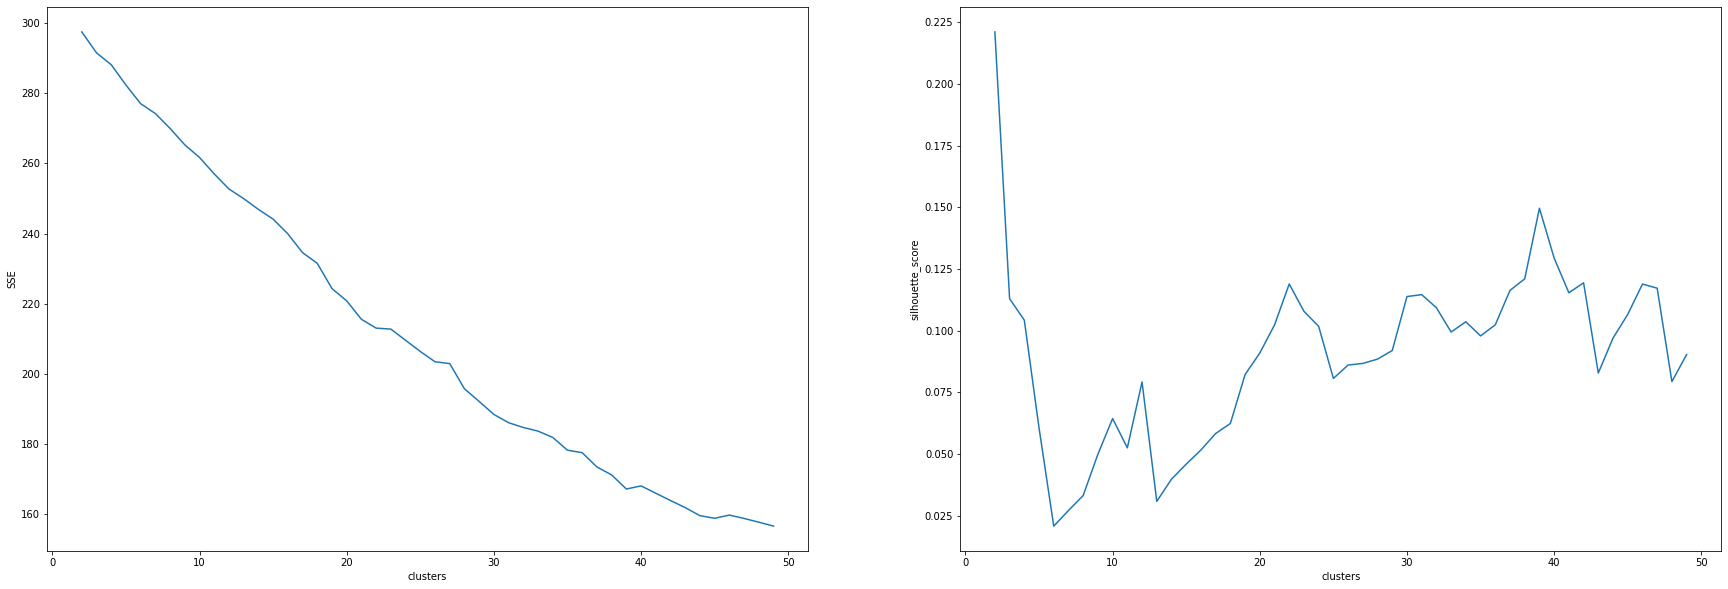

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(30,10))
sns.lineplot(data=scores_df, y='SSE', x='clusters', ax=axs[0])
sns.lineplot(data=scores_df, y='silhouette_score', x='clusters', ax=axs[1])

## Use K-means with 14 cluster to get some stats from the clusters

In [ ]:
initial_centers = random_center_initializer(normalized_data, 14, random_state=5).initialize()
kmeans_inst = kmeans(normalized_data, initial_centers=initial_centers, metric=distance_metric(1))
kmeans_inst.process()
clusters = kmeans_inst.get_clusters()

encoding = kmeans_inst.get_cluster_encoding()
encoder = cluster_encoder(encoding, clusters, normalized_data)
labels = encoder.set_encoding(0).get_clusters()
df_pol_conc['cluster_label'] = labels

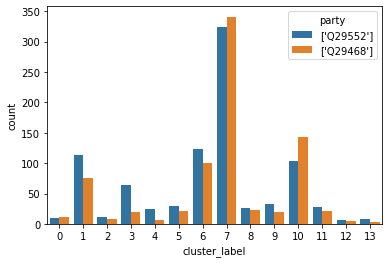

In [ ]:
df_pol_merged_only_dem_rep = df_pol_conc[(df_pol_conc['party'] == "['Q29552']") | (df_pol_conc['party'] == "['Q29468']")]
sns.countplot(x="cluster_label", hue="party", data=df_pol_merged_only_dem_rep)

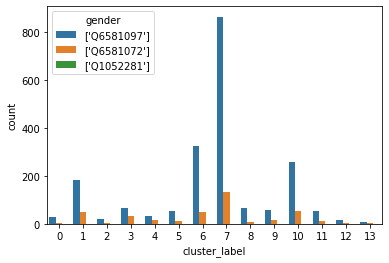

In [ ]:
sns.countplot(x="cluster_label", hue="gender", data=df_pol_conc)

## Let's check in which cluster we find John Kerry

In [ ]:
df_pol_conc[df_pol_conc['label'] == 'John Kerry'].iloc[0]['cluster_label']

3

## Which latent dimension is stongest for John Kerry?

In [ ]:
kerry_idx = df_pol_conc.index.get_loc(df_pol_conc[df_pol_conc['label'] == 'John Kerry'].iloc[0].name)
kerry_nmf = nmf[kerry_idx,:]
strongest_idx = np.argmax(kerry_nmf)
strongest_idx

5

In [ ]:
words = np.array(vectorizer.get_feature_names())
weights = nmf_instance.components_[5]
top_words = (-weights).argsort()[:20]
words.take(top_words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['biden', 'bernie', 'joe', 'sanders', 'campaign', 'democratic',
       'party', 'candidate', 'iowa', 'win', 'trump', 'donald', 'race',
       'country', 'voters', 'south', 'candidates', 'carolina',
       'democrats', 'vote'], dtype='<U33')

In [ ]:
def find_representative(df, k):
  return df.index.get_loc(df[df['cluster_label'] == k].iloc[0].name),df[df['cluster_label'] == k].iloc[0].label

In [ ]:
words = np.array(vectorizer.get_feature_names())
for k in range(0,7):
  index, representative = find_representative(df_pol_conc,k)
  representative_nmf = nmf[index,:]
  strongest_idx = np.argmax(representative_nmf)
  weights = nmf_instance.components_[strongest_idx]
  top_words = (-weights).argsort()[:20]
  words.take(top_words)
  print("%s is in cluster %d, and top words are " % (representative,k))
  print(words[top_words])
  print("\n")

Mike Pompeo is in cluster 0, and top words are 
['world' 'china' 'united' 'states' 'american' 'america' 'chinese'
 'country' 'trade' 'americans' 'coronavirus' 'countries' 'virus'
 'communist' 'global' 'freedom' 'president' 'international' 'deal'
 'agreement']


Ben Carson is in cluster 1, and top words are 
['people' 'help' 'doing' 'way' 'understand' 'right' 'job' 'country'
 'taking' 'working' 'thing' 'afraid' 'live' 'outside' 'attention' 'self'
 'fear' 'away' 'living' 'drug']


James Franklin Jeffrey is in cluster 2, and top words are 
['make' 'sure' 'work' 'right' 'thing' 'decision' 'difference' 'able' 'll'
 'decisions' 'use' 'sort' 'making' 'wanted' 'help' 'folks' 'place'
 'support' 'everybody' 'doing']


David Loebsack is in cluster 3, and top words are 
['biden' 'bernie' 'joe' 'sanders' 'campaign' 'democratic' 'party'
 'candidate' 'iowa' 'win' 'trump' 'donald' 'race' 'country' 'voters'
 'south' 'candidates' 'carolina' 'democrats' 'vote']


Jared Ball is in cluster 4, and top words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 2019

In [ ]:
df_politicians = pd.read_csv("/content/drive/MyDrive/ADA/politicians_2019.csv")
df_meta = pd.read_csv("/content/drive/MyDrive/ADA/meta.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print(df_politicians.shape)
df_politicians.qids = df_politicians.qids.apply(literal_eval)
df_pol_exp = df_politicians.explode('qids')
df_meta_politicians = df_meta[df_meta.occupation.apply(lambda x: 'Q82955' in x)]

df_pol_exp['quote_conc']= df_pol_exp.groupby(['qids'])['quotation'].transform(lambda x: ','.join(x))
df_pol_exp = df_pol_exp.drop_duplicates(subset=['qids'])
df_pol_conc = df_pol_exp.merge(df_meta_politicians, how='inner', left_on='qids', right_on='id')
df_pol_conc = df_pol_conc.drop_duplicates(subset=['quotation'])
df_pol_conc

(1306702, 9)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_conc,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,2019-04-08-048753,It is immoral. It is harmful. It is hurtful.,President Donald Trump,Q22686,2019-04-08 16:22:00,44,"[['President Donald Trump', '0.5802'], ['None'...",['https://www.mercedsunstar.com/news/business/...,E,"It is immoral. It is harmful. It is hurtful.,I...",['Donald John Trump' 'Donald J. Trump' 'Trump'...,['+1946-06-14T00:00:00Z'],['Q30'],['Q6581097'],1395141850,NaN,NaN,['Q911554' 'Q557880' 'Q3427922' 'Q15980158' 'Q...,['Q29468' 'Q1897793' 'Q29552' 'Q29468' 'Q29468'],['Q787674'],Q22686,Donald Trump,['Q699872' 'Q22923830' 'Q38051523'],item,['Q178169']
1,2019-06-28-043094,It is my view that the answer to their problem...,Marco Rubio,Q324546,2019-06-28 21:54:17,1,"[['Marco Rubio', '0.7263'], ['None', '0.2737']]",['http://www.breitbart.com/politics/2019/06/28...,E,It is my view that the answer to their problem...,['Marco Antonio Rubio'],['+1971-05-28T00:00:00Z'],['Q30'],['Q6581097'],1393345921,NaN,R000595,['Q82955' 'Q40348'],['Q29468'],['Q1765120' 'Q1540185'],Q324546,Marco Rubio,NaN,item,['Q1841' 'Q7361618']
2,2019-08-27-000524,2008 campaign until now.,Barack Obama,Q76,2019-08-27 21:49:00,1,"[['Barack Obama', '0.9091'], ['None', '0.0909']]",['https://www.onenewspage.com/n/World/1zkjb06t...,E,"2008 campaign until now.,A couple of times a m...",['Barack Hussein Obama II' 'Barack Obama II' '...,['+1961-08-04T00:00:00Z'],['Q30'],['Q6581097'],1395141963,['Q49085' 'Q6935055' 'Q12826303' 'Q6392846'],O000167,['Q82955' 'Q40348' 'Q15958642' 'Q28532974' 'Q3...,['Q29552'],['Q1765120' 'Q1540185'],Q76,Barack Obama,['Q3586671' 'Q45578' 'Q4226' 'Q4791768' 'Q1706...,item,['Q23540' 'Q1062789' 'Q960252' 'Q426316']
3,2019-07-02-000595,60-ton battle tanks... would likely do signifi...,Eleanor Holmes Norton,Q461649,2019-07-02 03:19:00,1,"[['Eleanor Holmes Norton', '0.9274'], ['None',...",['http://feeds.cbsnews.com/~r/CBSNewsMain/~3/F...,E,60-ton battle tanks... would likely do signifi...,['Ms. Holmes Norton' 'Ms. Norton'],['+1937-06-13T00:00:00Z'],['Q30'],['Q6581072'],1392587001,['Q49085'],N000147,['Q82955' 'Q1622272' 'Q40348'],['Q29552'],NaN,Q461649,Eleanor Holmes Norton,NaN,item,['Q682443']
4,2019-03-18-044267,It just didn't do anything for anybody.,Lee Carter,Q42886824,2019-03-18 00:00:00,1,"[['Lee Carter', '0.7062'], ['None', '0.2938']]",['http://feeds.foxnews.com/~r/foxnews/politics...,E,"It just didn't do anything for anybody.,Alexa ...",['Lee Jin Carter' 'Lee Carter'],['+1987-06-02T00:00:00Z'],['Q30'],['Q6581097'],1393410444,NaN,NaN,['Q82955'],['Q29552'],NaN,Q42886824,Lee J. Carter,['Q60528250'],item,['Q1622507']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518,2019-06-18-043906,If you're in your 20s and 30s and you have MS ...,Rick Hardcastle,Q16187102,2019-06-18 02:17:15,1,"[['Rick Hardcastle', '0.9256'], ['None', '0.07...",['http://stripes.com/news/us/texans-may-have-t...,E,If you're in your 20s and 30s and you have MS ...,['Richard Lynn Hardcastle'],['+1956-04-06T00:00:00Z'],['Q30'],['Q6581097'],1393604600,NaN,NaN,['Q82955' 'Q1524582'],['Q29468'],NaN,Q16187102,Rick Hardcastle,NaN,item,NaN
3519,2019-07-04-019786,"I have to hand it to the industry, they have a...",Marge Davis,Q6760269,2019-07-04 09:00:29,4,"[['Marge Davis', '0.8071'], ['None', '0.1929']]",['https://www.nytimes.com/2019/07/04/business/...,E,"I have to hand it to the industry, they have a...",['Marjorie Ann Anderson' 'Marjorie Ann Davis' ...,['+1932-04-21T00:00:00Z'],['Q30'],['Q6581072'],1392666251,NaN,NaN,['Q82955'],NaN,NaN,Q6760269,Marge Anderson,NaN,item,NaN
3520,2019-02-18-081914,"to a good approximation, all [ animal ] specie...",Sir Robert May,Q336397,2019-02-18 13:17:40,6,"[['Sir Robert May', '0.8976'], ['None', '0.102...",['https://phys.org/news/2019-02-natural-world-..

In [ ]:
df_pol_conc["gender_string"] = df_pol_conc["gender"].apply(lambda x : "Male" if (x=="['Q6581097']")  else "Female" if (x=="['Q6581072']") else "Other")

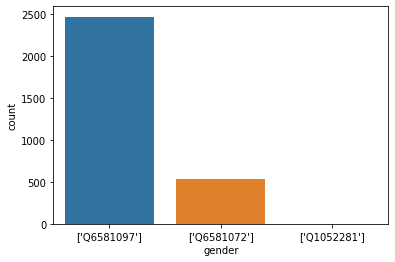

In [ ]:
sns.countplot(x="gender", data=df_pol_conc)

In [ ]:
import plotly.express as px
# This dataframe has 244 lines, but 4 distinct values for `day`
fig = px.pie(df_pol_conc, names='gender_string')
fig.show()
fig.write_html("piechart.html")

In [ ]:
df_pol_conc["party_string"] = df_pol_conc["party"].apply(lambda x : "Republican" if (x=="['Q29468']")  else "Democratic" if (x=="['Q29552']") else "Other")
fig = px.pie(df_pol_conc, names='party_string')
fig.show()
fig.write_html("piechart_party_2019.html")

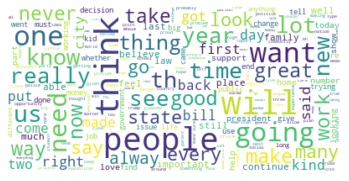

In [ ]:
from wordcloud import WordCloud
# lower max_font_size
wordcloud = WordCloud(max_font_size=40, background_color='white').generate(df_pol_conc.quote_conc.to_string())
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_2019.png", dpi=300)
plt.show()

In [ ]:
def find_representative(df, k):
  return df.index.get_loc(df[df['cluster_label'] == k].iloc[0].name),df[df['cluster_label'] == k].iloc[0].label

def cluster_and_print_stats(df_pol_conc):
    corpus = df_pol_conc['quotation'].to_list()
    vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    vectorizer = vectorizer.fit(corpus)

    vectorized_concat = vectorizer.transform(df_pol_conc['quote_conc'])
    nmf_instance = NMF(50, random_state = 1)
    nmf = nmf_instance.fit_transform(vectorized_concat)

    normalized_data = normalize(nmf, norm='l1')
    initial_centers = random_center_initializer(normalized_data, 14, random_state=5).initialize()
    kmeans_inst = kmeans(normalized_data, initial_centers=initial_centers, metric=distance_metric(1))
    kmeans_inst.process()
    clusters = kmeans_inst.get_clusters()

    encoding = kmeans_inst.get_cluster_encoding()
    encoder = cluster_encoder(encoding, clusters, normalized_data)
    labels = encoder.set_encoding(0).get_clusters()
    df_pol_conc['cluster_label'] = labels


    words = np.array(vectorizer.get_feature_names())
    for k in range(0,14):
        index, representative = find_representative(df_pol_conc,k)
        representative_nmf = nmf[index,:]
        strongest_idx = np.argmax(representative_nmf)
        weights = nmf_instance.components_[strongest_idx]
        top_words = (-weights).argsort()[:20]
        words.take(top_words)
        print("%s is in cluster %d, and top words are " % (representative,k))
        print(words[top_words])
        print("\n")

In [ ]:
cluster_and_print_stats(df_pol_conc)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



Betty Boyd is in cluster 0, and top words are 
['going' 'lot' 'things' 'thing' 'happen' 'come' 'coming' 'strong' 'doing'
 'probably' 'say' 'end' 'talking' 'getting' 'asking' 'gon' 'business'
 'care' 'hard' 'open']


Bill de Blasio is in cluster 1, and top words are 
['city' 'mayor' 'housing' 'council' 'residents' 'affordable' 'cities'
 'boston' 'street' 'downtown' 'project' 'streets' 'development' 'san'
 'building' 'neighborhood' 'neighborhoods' 'work' 'transportation'
 'seattle']


Jeff Landry is in cluster 2, and top words are 
['law' 'court' 'case' 'justice' 'enforcement' 'rule' 'cases' 'decision'
 'supreme' 'federal' 'does' 'general' 'defendant' 'religious' 'claims'
 'legal' 'constitutional' 'courts' 'laws' 'statute']


David Linsky is in cluster 3, and top words are 
['massachusetts' 'commonwealth' 'virginia' 'housing' 'senate' 'governor'
 'communities' 'house' 'legislation' 'funding' 'education' 'budget'
 'legislature' 'boston' 'local' 'important' 'residents' 'revenue'
 'transpor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
index, representative = find_representative(df_pol_conc,6)
representative_nmf = nmf[index,:]
strongest_idx = np.argmax(representative_nmf)
weights = nmf_instance.components_[strongest_idx]
word_weight = {a: b for a, b in zip(words, weights)}



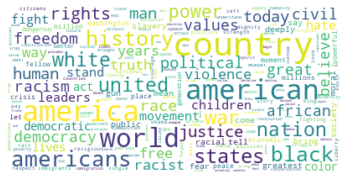

In [ ]:
from wordcloud import WordCloud
# lower max_font_size
wordcloud = WordCloud(max_font_size=40, background_color='white').fit_words(word_weight)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

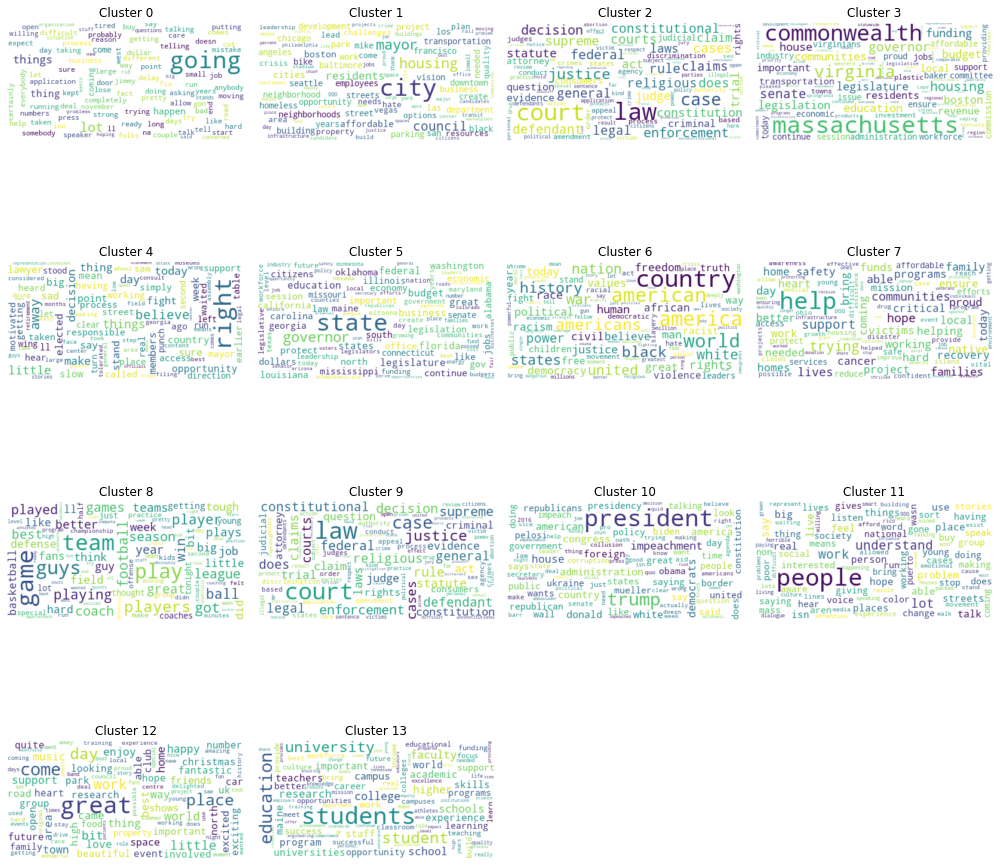

In [ ]:
from math import floor
fig, axs = plt.subplots(4,4, figsize=(14,14))
fig.delaxes(axs[3][2])
fig.delaxes(axs[3][3])
sbplt = axs.flatten()
for k in range(0,14):
  #sbplt = axs[floor((k-1)/4), (k-1)%4]
  index, representative = find_representative(df_pol_conc,k)
  representative_nmf = nmf[index,:]
  strongest_idx = np.argmax(representative_nmf)
  weights = nmf_instance.components_[strongest_idx]
  word_weight = {a: b for a, b in zip(words, weights)}
  wordcloud = WordCloud(max_font_size=40, background_color='white', max_words=100).fit_words(word_weight)
  sbplt[k].axis("off")
  sbplt[k].imshow(wordcloud, interpolation="bilinear")
  sbplt[k].set_title("Cluster "+ str(k))
fig.tight_layout()

In [ ]:
fig.savefig('cluster_words_2019.png', dpi=300)

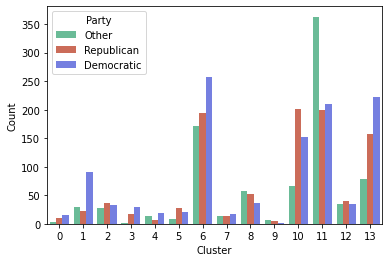

In [ ]:
ax = sns.countplot(x="cluster_label", hue="party_string", data=df_pol_conc, palette=['#5cc899','#de5f46','#6371f2'])
ax.set(xlabel='Cluster', ylabel='Count')
ax.legend(title = 'Party')
fig = ax.get_figure()
plt.savefig("party_hist_2019.png", dpi=300)

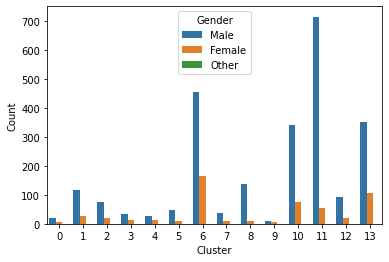

In [ ]:
ax = sns.countplot(x="cluster_label", hue="gender_string", data=df_pol_conc)
ax.set(xlabel='Cluster', ylabel='Count')
ax.legend(title = 'Gender')
fig = ax.get_figure()
plt.savefig("gender_hist_2019.png", dpi=300)

#2018 comparison

In [ ]:
df_politicians = pd.read_csv("/content/drive/MyDrive/ADA/politicians_2018.csv")
df_politicians.qids = df_politicians.qids.apply(literal_eval)
df_pol_exp = df_politicians.explode('qids')
df_meta_politicians = df_meta[df_meta.occupation.apply(lambda x: 'Q82955' in x)]

df_pol_exp['quote_conc']= df_pol_exp.groupby(['qids'])['quotation'].transform(lambda x: ','.join(x))
df_pol_exp = df_pol_exp.drop_duplicates(subset=['qids'])
df_pol_conc = df_pol_exp.merge(df_meta_politicians, how='inner', left_on='qids', right_on='id')
df_pol_conc = df_pol_conc.drop_duplicates(subset=['quotation'])
df_pol_conc

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_conc,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,2018-05-07-000752,"25 years later, he was finally located in his ...",Sarah Huckabee Sanders,Q27986907,2018-05-07 19:08:20,1,"[['Sarah Huckabee Sanders', '0.8623'], ['None'...",['http://sanfrancisco.cbslocal.com/2018/05/07/...,E,"25 years later, he was finally located in his ...",['Sarah Huckabee' 'Sarah Huckabee Sanders'\n '...,['+1982-08-13T00:00:00Z'],['Q30'],['Q6581072'],1392219419,NaN,NaN,['Q82955' 'Q1388151' 'Q4198314'],['Q29468'],NaN,Q27986907,Sarah Sanders,NaN,item,['Q93191']
1,2018-09-14-000910,"60 Second Fact Check with Jane Timm,",President Trump,Q22686,2018-09-14 01:47:10,1,"[['President Trump', '0.882'], ['None', '0.118']]",['http://nbcnews.com/video/fact-check-did-trum...,E,"60 Second Fact Check with Jane Timm,,A constru...",['Donald John Trump' 'Donald J. Trump' 'Trump'...,['+1946-06-14T00:00:00Z'],['Q30'],['Q6581097'],1395141850,NaN,NaN,['Q911554' 'Q557880' 'Q3427922' 'Q15980158' 'Q...,['Q29468' 'Q1897793' 'Q29552' 'Q29468' 'Q29468'],['Q787674'],Q22686,Donald Trump,['Q699872' 'Q22923830' 'Q38051523'],item,['Q178169']
2,2018-03-10-000696,"a clear message that optics matter,",John Kelly,Q16190651,2018-03-10 01:44:52,16,"[['John Kelly', '0.5109'], ['None', '0.3766'],...",['http://erietvnews.com/story/37692349/white-h...,E,"a clear message that optics matter,,Just a hab...",NaN,['+1960-02-02T00:00:00Z'],['Q27'],['Q6581097'],1330121343,NaN,NaN,['Q82955'],['Q503614'],NaN,Q16190651,John Kelly,NaN,item,NaN
4,2018-01-26-001332,A councillor's time is as valuable as anyone e...,John Dean,Q1630448,2018-01-26 15:23:25,2,"[['John Dean', '0.9677'], ['None', '0.0323']]",['http://www.whtimes.co.uk/council-leader-john...,E,A councillor's time is as valuable as anyone e...,['John Wesley Dean III'],['+1938-10-14T00:00:00Z'],['Q30'],['Q6581097'],1392941678,NaN,NaN,['Q1086863' 'Q185351' 'Q40348' 'Q82955' 'Q2883...,['Q29468' 'Q327591'],NaN,Q1630448,John Dean,NaN,item,NaN
5,2018-02-07-001740,A disproportionate number of the MS-13 members...,Peter King,Q7175195,2018-02-07 05:00:00,2,"[['Peter King', '0.5021'], ['None', '0.4344'],...",['https://www.wsws.org/en/articles/2018/02/07/...,E,A disproportionate number of the MS-13 members...,NaN,['+1952-06-29T00:00:00Z'],['Q408'],['Q6581097'],1316853316,NaN,NaN,['Q82955'],['Q241149'],NaN,Q7175195,Peter King,NaN,item,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,2018-02-03-031155,"If I never get elected again, I have to stand ...",Jacob E. Patterson,Q6104059,2018-02-03 00:43:04,3,"[['Jacob E. Patterson', '0.7938'], ['None', '0...","['http://familypedia.wikia.com/wiki/J._E._""Pat...",E,"If I never get elected again, I have to stand ...",['J.E. Patterson'],['+1924-04-28T00:00:00Z'],['Q30'],['Q6581097'],1392529389,NaN,NaN,['Q82955' 'Q43845'],['Q29552'],NaN,Q6104059,Jacob E. Patterson,NaN,item,NaN
3710,2018-09-10-069000,poor fellows who just wanted to go home.,Eleanor Kinnaird,Q1325732,2018-09-10 15:54:05,1,"[['Eleanor Kinnaird', '0.658'], ['None', '0.34...",['http://www.newsobserver.com/opinion/letters-...,E,poor fellows who just wanted to go home.,['Eleanor G. Kinnaird' 'Ellie Kinnaird'],['+1931-11-14T00:00:00Z'],['Q30'],['Q6581072'],1392769508,NaN,NaN,['Q82955'],['Q29552'],NaN,Q1325732,Eleanor Kinnaird,NaN,item,NaN
3711,2018-03-16-132866,"They Were My Friends-Jack, Bob & Ted: My Life ...",Gerard F. Doherty,Q5549993,2018-03-16 12:27:35,1,"[['Gerard F. Doherty', '0.9178'], ['None', '0....",['http://www.masslive.com/news/index.ssf/2018/...,E,"They Were My Friends-Jack, Bob & Ted: My Life ...",['Gerard Doherty' 'Gerard F. Doherty' 'Doherty...,['+1928-04-06T00:00:00Z'],['Q30'],['Q6581097'],1395373148,NaN,NaN,['Q82955' 'Q11986654' 'Q40348'],['Q29552'],NaN,Q5549993,Gerard Francis Doherty,NaN,item,NaN
3712,201

In [ ]:
df_pol_conc["gender_string"] = df_pol_conc["gender"].apply(lambda x : "Male" if (x=="['Q6581097']")  else "Female" if (x=="['Q6581072']") else "Other")
df_pol_conc["party_string"] = df_pol_conc["party"].apply(lambda x : "Republican" if (x=="['Q29468']")  else "Democratic" if (x=="['Q29552']") else "Other")

In [ ]:
cluster_and_print_stats(df_pol_conc)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



Andrew Cuomo is in cluster 0, and top words are 
['new' 'york' 'jersey' 'yorkers' 'mexico' 'hampshire' 'cuomo' 'albany'
 'world' 'corruption' 'fight' 'economic' 'protect' 'queens' 'day'
 'families' 'jobs' 'country' 'greatest' 'tax']


Brian Mast is in cluster 1, and top words are 
['water' 'river' 'project' 'area' 'local' 'california' 'safety' 'lake'
 'michigan' 'clean' 'high' 'level' 'building' 'use' 'valley' 'major'
 'used' 'means' 'gas' 'systems']


Phil Hare is in cluster 2, and top words are 
['like' 'feel' 'love' 'kids' 'looks' 'man' 'make' 'kind' 'thing' 'away'
 'wanted' 'fun' 'used' 'guy' 'music' 'happy' 'doesn' 'everybody' 'night'
 'little']


Sarah Sanders is in cluster 3, and top words are 
['president' 'white' 'house' 'states' 'united' 'american' 'bush' 'vice'
 'great' 'security' 'job' 'obama' 'say' 'administration' 'press' 'john'
 'kavanaugh' 'country' 'office' 'chief']


Betsy DeVos is in cluster 4, and top words are 
['students' 'school' 'education' 'schools' 'university

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



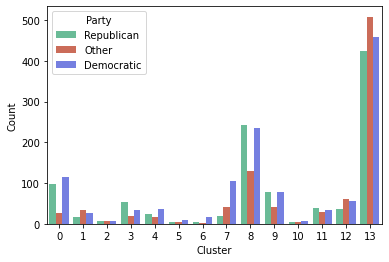

In [ ]:
ax = sns.countplot(x="cluster_label", hue="party_string", data=df_pol_conc, palette=['#5cc899','#de5f46','#6371f2'])
ax.set(xlabel='Cluster', ylabel='Count')
ax.legend(title = 'Party')
fig = ax.get_figure()
plt.savefig("party_hist_todo.png", dpi=300)

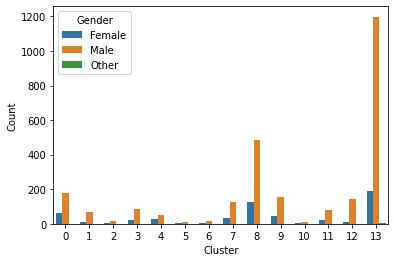

In [ ]:
ax = sns.countplot(x="cluster_label", hue="gender_string", data=df_pol_conc)
ax.set(xlabel='Cluster', ylabel='Count')
ax.legend(title = 'Gender')
fig = ax.get_figure()
plt.savefig("gender_hist_todo.png", dpi=300)

In [ ]:
df_education_2018 = df_pol_conc[df_pol_conc["cluster_label"] == 4]
fig = px.pie(df_education_2018, names='party_string')
fig.show()
#fig.write_html("piechart_party_2019.html")

#2017

In [ ]:
df_politicians = pd.read_csv("/content/drive/MyDrive/ADA/politicians_2017.csv")
df_politicians.qids = df_politicians.qids.apply(literal_eval)
df_pol_exp = df_politicians.explode('qids')
df_meta_politicians = df_meta[df_meta.occupation.apply(lambda x: 'Q82955' in x)]

df_pol_exp['quote_conc']= df_pol_exp.groupby(['qids'])['quotation'].transform(lambda x: ','.join(x))
df_pol_exp = df_pol_exp.drop_duplicates(subset=['qids'])
df_pol_conc = df_pol_exp.merge(df_meta_politicians, how='inner', left_on='qids', right_on='id')
df_pol_conc = df_pol_conc.drop_duplicates(subset=['quotation'])

In [ ]:
df_pol_conc["gender_string"] = df_pol_conc["gender"].apply(lambda x : "Male" if (x=="['Q6581097']")  else "Female" if (x=="['Q6581072']") else "Other")
df_pol_conc["party_string"] = df_pol_conc["party"].apply(lambda x : "Republican" if (x=="['Q29468']")  else "Democratic" if (x=="['Q29552']") else "Other")

In [ ]:
corpus = df_pol_conc['quotation'].to_list()
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
vectorizer = vectorizer.fit(corpus)

vectorized_concat = vectorizer.transform(df_pol_conc['quote_conc'])
nmf_instance = NMF(50, random_state = 1)
nmf = nmf_instance.fit_transform(vectorized_concat)

normalized_data = normalize(nmf, norm='l1')
initial_centers = random_center_initializer(normalized_data, 14, random_state=5).initialize()
kmeans_inst = kmeans(normalized_data, initial_centers=initial_centers, metric=distance_metric(1))
kmeans_inst.process()
clusters = kmeans_inst.get_clusters()

encoding = kmeans_inst.get_cluster_encoding()
encoder = cluster_encoder(encoding, clusters, normalized_data)
labels = encoder.set_encoding(0).get_clusters()
df_pol_conc['cluster_label'] = labels

words = np.array(vectorizer.get_feature_names())
for k in range(0,14):
  index, representative = find_representative(df_pol_conc,k)
  representative_nmf = nmf[index,:]
  strongest_idx = np.argmax(representative_nmf)
  weights = nmf_instance.components_[strongest_idx]
  top_words = (-weights).argsort()[:20]
  words.take(top_words)
  print("%s is in cluster %d, and top words are " % (representative,k))
  print(words[top_words])
  print("\n")

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



Kim Reynolds is in cluster 0, and top words are 
['work' 'families' 'help' 'support' 'communities' 'working' 'continue'
 'jobs' 'important' 'ensure' 'program' 'forward' 'businesses' 'efforts'
 'provide' 'local' 'future' 'economy' 'great' 'veterans']


Doug Jones is in cluster 1, and top words are 
['party' 'election' 'republican' 'voters' 'democratic' 'vote' 'democrats'
 'republicans' 'campaign' 'political' 'politics' 'candidates' 'elections'
 'change' 'alabama' 'candidate' 'conservative' 'district' 'race' 'voting']


Betty Jefferson is in cluster 2, and top words are 
['like' 'feel' 'kind' 'looks' 'music' 'old' 'make' 'wouldn' 'll' 'easy'
 'look' 'little' 'kid' 'big' 'fun' 'used' 'things' 'thought' 'learn'
 'felt']


Joshua Bolten is in cluster 3, and top words are 
['tax' 'reform' 'taxes' 'money' 'budget' 'business' 'income' 'pay'
 'businesses' 'government' 'spending' 'percent' 'economy' 'obamacare'
 'cut' 'taxpayers' 'cuts' 'jobs' 'growth' 'middle']


Patricia Roybal Caballero is in

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
def getCorpus():
  paths = ["/content/drive/MyDrive/ADA/politicians.csv",
           "/content/drive/MyDrive/ADA/politicians_2019.csv",
           "/content/drive/MyDrive/ADA/politicians_2018.csv",
          ]
  corpus = []
  for path in paths:
    print('Reading ' + path)
    df = pd.read_csv(path)
    corpus = corpus + df['quotation'].to_list()
  return corpus

In [ ]:
corpus = getCorpus()

Reading /content/drive/MyDrive/ADA/politicians.csv
Reading /content/drive/MyDrive/ADA/politicians_2019.csv
Reading /content/drive/MyDrive/ADA/politicians_2018.csv


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
vectorizer = vectorizer.fit(corpus)

In [ ]:
def getSimilarityForPair(df_politicians):
  df_pol_exp = df_politicians.explode('qids')
  df_meta_politicians = df_meta[df_meta.occupation.apply(lambda x: 'Q82955' in x)]
  df_pol_exp['quote_conc']= df_pol_exp.groupby(['qids'])['quotation'].transform(lambda x: ','.join(x))
  df_pol_exp = df_pol_exp.drop_duplicates(subset=['qids'])

  df_meta_politicians = df_meta_politicians.dropna(subset=['party'])
  df_meta_politicians['party'] = df_meta_politicians.apply(lambda x: x['party'].split("'")[-2], axis = 1)

  df_pol_conc = df_pol_exp.merge(df_meta_politicians, how='inner', left_on='qids', right_on='id')
  df_pol_conc = df_pol_conc.drop_duplicates(subset=['quotation'])
  
  vectorized_concat = vectorizer.transform(df_pol_conc['quote_conc'])
  nmf_instance = NMF(50, random_state = 1)
  nmf = nmf_instance.fit_transform(vectorized_concat)

  kerry_idx = df_pol_conc.index.get_loc(df_pol_conc[df_pol_conc['id'] == 'Q22316'].iloc[0].name)
  biden_idx = df_pol_conc.index.get_loc(df_pol_conc[df_pol_conc['id'] == 'Q6279'].iloc[0].name)
  return cosine_similarity(nmf[kerry_idx].reshape(1, -1), nmf[biden_idx].reshape(1, -1))

In [ ]:
paths = ["/content/drive/MyDrive/ADA/politicians.csv",
           "/content/drive/MyDrive/ADA/politicians_2019.csv",
           "/content/drive/MyDrive/ADA/politicians_2018.csv",
        ]
similarities = []

for path in paths:
  df_politicians = pd.read_csv(path)
  df_politicians.qids = df_politicians.qids.apply(literal_eval)
  similarity = getSimilarityForPair(df_politicians)
  similarities.append(similarity)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: Fu

In [ ]:
sim_clean = [x[0][0] for x in similarities]
sim_clean.reverse()

In [4]:
years = ['2018', '2019', '2020']
sim_dict = {'Year': years, 'Similarity': sim_clean}
df = pd.DataFrame(sim_dict)

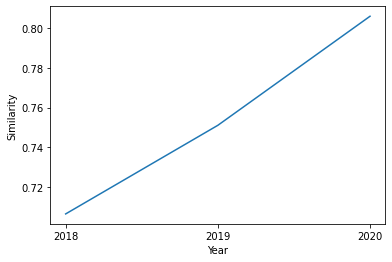

In [6]:
ax = sns.lineplot(data=df, x='Year', y='Similarity', markers='o')
fig = ax.get_figure()
fig.savefig('sim_graph.png')

# Time Series

In [6]:
politicians.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
57,"[Elisha Meredith, Elisha Edward Meredith]",[+1848-12-26T00:00:00Z],[Q30],[Q6581097],1395914283,None,M000647,"[Q82955, Q40348]",[Q29552],None,Q3251,Elisha E. Meredith,None,item,None
79,"[Willard Mitt Romney, Pierre Delecto]",[+1947-03-12T00:00:00Z],[Q30],[Q6581097],1393565531,None,R000615,"[Q82955, Q15978655, Q43845, Q15980158, Q219477]",[Q29468],"[Q1765120, Q191701, Q1540185]",Q4496,Mitt Romney,"[Q937607, Q4226, Q4791860, Q17100322]",item,[Q42504]
196,"[Richard Milhous Nixon, Nixon, President Nixon...",[+1913-01-09T00:00:00Z],[Q30],[Q6581097],1393886022,None,N000116,"[Q82955, Q189290, Q40348, Q18814623, Q372436]",[Q29468],None,Q9588,Richard Nixon,"[Q7891408, Q693742, Q699590, Q644161, Q1701660...",item,[Q170208]


In [7]:
list_aliases= []
for i,line in enumerate(politicians.aliases.values):
    copy_line = line[:]
    copy_line = np.append(politicians.label.values[i],copy_line)
    list_aliases.append(copy_line)
    
aliases_politicians = pd.DataFrame(list_aliases)

In [8]:
aliases_politicians.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,George Washington,Washington,President Washington,G. Washington,Father of the United States,The American Fabius,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,George W. Bush,George Walker Bush,Bush Jr.,Dubya,GWB,Bush 43,President George W. Bush,George Bush,President Bush,Bush,...,None,None,None,None,None,None,None,None,None,None
2,Elisha E. Meredith,Elisha Meredith,Elisha Edward Meredith,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Mitt Romney,Willard Mitt Romney,Pierre Delecto,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Richard Nixon,Richard Milhous Nixon,Nixon,President Nixon,Dick Nixon,Tricky Dick,R. Nixon,R. M. Nixon,Richard M. Nixon,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
df_politicians_all_years = [pd.read_csv(f"/content/drive/MyDrive/ADA/politicians_{i}.csv") for i in range(2015,2021)] # We put all the dataframes of politicians' quotes of each year in a list

In [9]:
def create_signal(aliases, df_politicians):
    """
    Create a signal of the number of quotes per week, made by a politician.
    Arguments:
        name: name of the politician
    """
    #signal = np.zeros([53,1])
    # We extract different ways to call him in the df

    # We extract all his quotes
    chunk = df_politicians[df_politicians.speaker.isin(aliases)]
    # We ectract all the weeks of eachs quotes
    weeks = chunk.date.apply(lambda x: x.week).values
    # We create an histogram of number of quotes per weeks
    signal, _ = np.histogram(weeks, range(1, 55))
    return signal

In [ ]:
# For each year we create a matrix with a line by politicians (order of the dataframe from wikidata dump), each line is the time serie of the politician for this year
for theyear in range(2015,2021):
    df_politicians = pd.read_csv(f"df_politicians_{theyear}.csv")
    df_politicians.date = pd.to_datetime(df_politicians.date)
    # do it for all years
    signals_politicians = [create_signal(aliases.values, df_politicians) for _,aliases in aliases_politicians.iterrows()]
    for i in range (len(signals_politicians)):
        signals_politicians[i] = signals_politicians[i].reshape((1,53))
    signals_politicians= np.concatenate(signals_politicians , axis=0)
    np.save(f'signals_politicians_{theyear}.npy',signals_politicians)

In [11]:
signals_politicians = [np.load(f"signals_politicians_{i}.npy") for i in range(2015,2021)]

In [13]:
idx_talking_this_year = [np.where(signals_politician.sum(axis=1) != 0) for signals_politician in signals_politicians] # Index of politicians talking at least once the year (for each year)

In [14]:
nb_years = len(signals_politicians)
signals_politicians_reduced = [signals_politicians[i][idx_talking_this_year[i]] for i in range(nb_years)] # We reduce the matrix by droping series of 0.
aliases_politicians_reduced = [aliases_politicians.iloc[idx_talking_this_year[i]] for i in range(nb_years)]
for i in range(nb_years):
    aliases_politicians_reduced[i].reset_index(inplace=True)
signals_politicians_reduced[-1] = signals_politicians_reduced[-1][:,:16] # Only 16 weeks in 2020 Quotebank

In [15]:
# function to decide the number of cluster (using kshape algorithm)
def plot_sse_kshape(features_X, start=2, end=50):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KShape(n_clusters=k, n_init=1, random_state=0).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})
        print(k)
    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    return sse

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


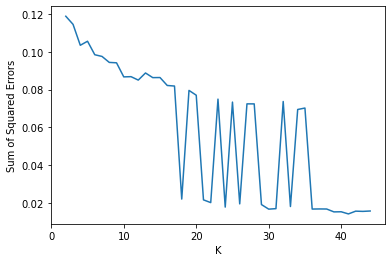

In [22]:
sse = plot_sse_kshape(signals_politicians_reduced[-1]) # We'll stay at 50 which is good

In [ ]:
K = 50
all_years_ks = [KShape(n_clusters=K, n_init=1, random_state=0).fit(signals_politicians_reduced[i]) for i in range(nb_years)] # Based on cross-correlation

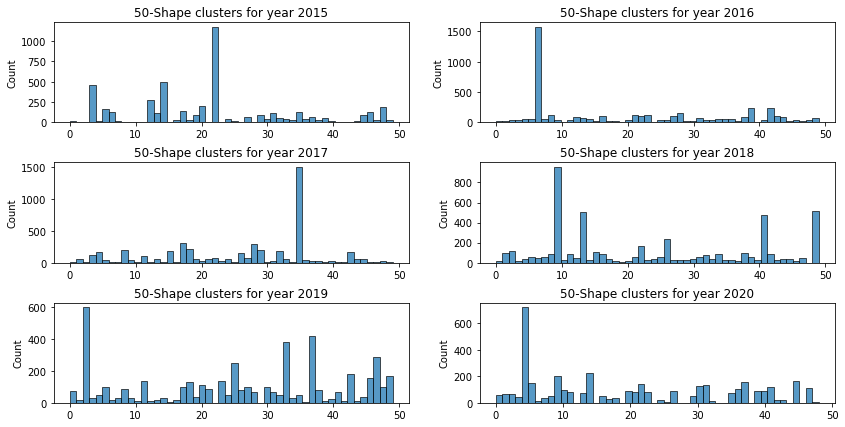

In [21]:
fig,axs = plt.subplots(3,2,figsize=(14,7))
plt.subplots_adjust(hspace=0.4)
axs = axs.flatten()
for i,(ax,ks) in enumerate(zip(axs,all_years_ks)):
    sns.histplot(data=ks.labels_, ax=ax, bins=K).set_title(f"{K}-Shape clusters for year {i+2015}")

In [33]:
aliases_politicians_reduced[-1][all_years_ks[-1].labels_ == 14][0].values[:10] # See a part of one cluster for 2020

array(['George W. Bush', 'Thomas Jefferson', 'Todd Young',
       'Tammy Baldwin', 'Cathy McMorris Rodgers', 'Al Sharpton',
       'Chuck Schumer', 'Andrew Dickson White', 'John Pérez',
       'Chris Murphy'], dtype=object)

In [34]:
all_year_politicians = [politicians.iloc[idx_talking_this_year[i]] for i in range(nb_years)]

In [37]:
for i in range(nb_years):
    all_year_politicians[i].reset_index(inplace=True)

We will analyse gender and party for each year in each clusters

In [86]:
all_year_gender = [all_year_politicians[i].gender.astype(str) for i in range(nb_years)]

In [87]:
all_year_gender = [pd.DataFrame({"gender" : all_year_gender[i], "cluster": all_years_ks[i].labels_}) for i in range(nb_years)]

In [88]:
all_year_party = [all_year_politicians[i].party.astype(str) for i in range(nb_years)]

In [89]:
all_year_party = [pd.DataFrame({"party" : all_year_party[i], "cluster": all_years_ks[i].labels_}) for i in range(nb_years)]

In [90]:
for i in range(nb_years):
    all_year_party[i] = all_year_party[i][all_year_party[i].party != "None"]
    all_year_party[i]["party"] = all_year_party[i]["party"].apply(lambda x : "Republican" if (x=="['Q29468']")  else "Democrate" if (x=="['Q29552']") else "Other")
    all_year_gender[i]["gender"] = all_year_gender[i]["gender"].apply(lambda x : "Male" if (x=="['Q6581097']")  else "Female" if (x=="['Q6581072']") else "Other")

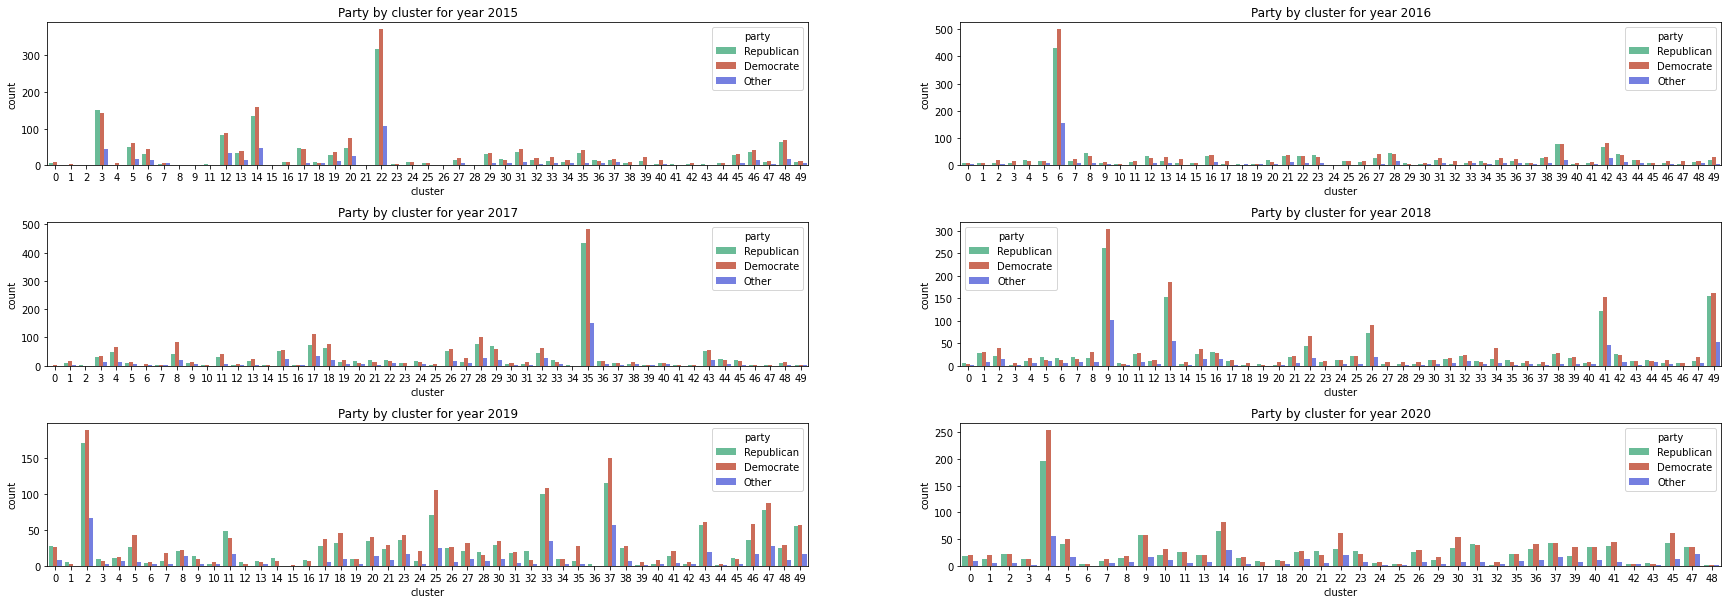

In [99]:
fig,axs = plt.subplots(3,2,figsize=(30,10))
plt.subplots_adjust(hspace=0.4)
axs = axs.flatten()
for year,(ax,ks,gender, party) in enumerate(zip(axs,all_years_ks,all_year_gender, all_year_party)):
    sns.countplot(x="cluster", hue="party", ax=ax, data=party, palette=['#5cc899','#de5f46','#6371f2']).set_title(f'Party by cluster for year {year+2015}')

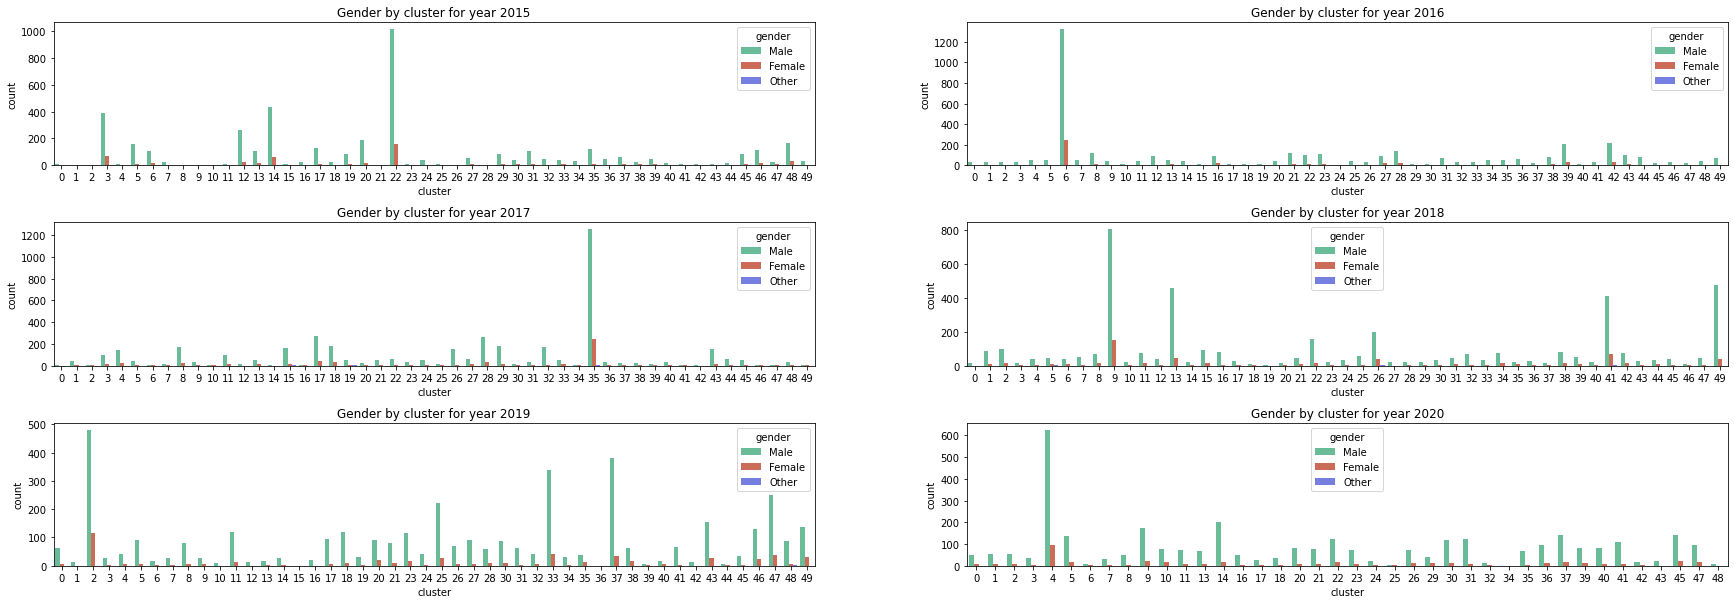

In [100]:
fig,axs = plt.subplots(3,2,figsize=(30,10))
plt.subplots_adjust(hspace=0.4)
axs = axs.flatten()
for year,(ax,ks,gender, party) in enumerate(zip(axs,all_years_ks,all_year_gender, all_year_party)):
    sns.countplot(x="cluster", hue="gender", ax=ax, data=gender, palette=['#5cc899','#de5f46','#6371f2']).set_title(f'Gender by cluster for year {year+2015}')

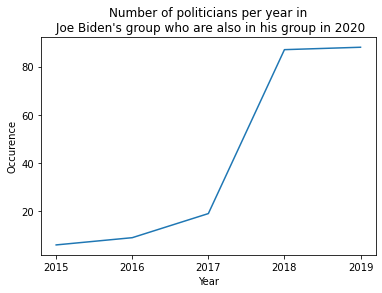

In [21]:
# Are people of cluster of Joe Biden same each years
all_year_joe_cluster_people = []
for i in range(nb_years):
    index_Joe = aliases_politicians_reduced[i][aliases_politicians_reduced[i]["0"] == "Joe Biden"]["index"].index[0]
    cluster_Joe = all_years_ks[i].labels_[index_Joe]
    all_year_joe_cluster_people.append(set(aliases_politicians_reduced[i][all_years_ks[i].labels_ == cluster_Joe]["0"].values))

nb_repetitions = {str(i+2015):len(list(all_year_joe_cluster_people[-1] & all_year_joe_cluster_people[i])) for i in range(nb_years-1)}
sns.lineplot(data=nb_repetitions).set(xlabel='Year', ylabel='Occurence', title="Number of politicians per year in\n Joe Biden's group who are also in his group in 2020");

In [23]:
correlation_Biden_Kerry={}
autocorrelation_Biden = {}
autocorrelation_Kerry = {}
for i in range(nb_years):
    print(f"Year {i+2015}")
    index_John = aliases_politicians_reduced[i][aliases_politicians_reduced[i][0] == "John Kerry"]["index"].index[0]
    cluster_John = all_years_ks[i].labels_[index_John]
    print(f'John Kerry is in cluster : {cluster_John}')
    index_Joe = aliases_politicians_reduced[i][aliases_politicians_reduced[i][0] == "Joe Biden"]["index"].index[0]
    cluster_Joe = all_years_ks[i].labels_[index_Joe]
    print(f'Joe Biden is in cluster : {cluster_Joe}')

    signal_John_normalized = signals_politicians_reduced[i][index_John]/signals_politicians_reduced[i][index_John].sum()
    signal_Joe_normalized =  signals_politicians_reduced[i][index_Joe]/signals_politicians_reduced[i][index_Joe].sum()

    correlation_Biden_Kerry[i+2015] = np.abs(np.correlate(signal_John_normalized, signal_Joe_normalized, 'full')).max()
    autocorrelation_Biden[i+2015] = np.abs(np.correlate(signal_Joe_normalized, signal_Joe_normalized)[0])
    autocorrelation_Kerry[i+2015] = np.abs(np.correlate(signal_John_normalized, signal_John_normalized)[0])

Year 2015
John Kerry is in cluster : 21
Joe Biden is in cluster : 31
Year 2016
John Kerry is in cluster : 15
Joe Biden is in cluster : 35
Year 2017
John Kerry is in cluster : 4
Joe Biden is in cluster : 17
Year 2018
John Kerry is in cluster : 26
Joe Biden is in cluster : 13
Year 2019
John Kerry is in cluster : 45
Joe Biden is in cluster : 37
Year 2020
John Kerry is in cluster : 0
Joe Biden is in cluster : 14


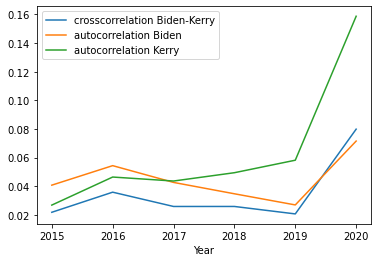

In [24]:
sns.lineplot(data=correlation_Biden_Kerry, label="crosscorrelation Biden-Kerry")
sns.lineplot(data=autocorrelation_Biden, label = "autocorrelation Biden")
sns.lineplot(data=autocorrelation_Kerry, label ="autocorrelation Kerry").set(xlabel='Year');